<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_06_V3AB_SingleChart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ॐ श्री गणेशाय नमः

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the LICENSE file in the root directory of this source tree.

#Single Chart Analysis | Ashtakvarga | Gochar

##Rationale

The core 'engine' of Parashar21 is designed to cast horoscopes using the [Python](https://pypi.org/project/pyswisseph/) version of the [Swiss Ephemeris](https://www.astro.com/swisseph/) software, convert the data to JSON format and then store the same in a MongoDB database.<br><br> While processing a single chart does not really need database engine we found it economical to skip another ground up development and retain the same code base. Moreover, the Mongo query language has been used to filter out horoscopes that meet certain criteria and then create human readable MS-Word documents for each selected horoscope. This search and filter operation would have been difficult without the MongoDB engine. <br> <br>
For full information about this project, please see the [Parashar21](https://prithwis.github.io/parashar21/) github page.


#SetUp Environment

##Install Software

In [1]:
!python --version
!lsb_release -a

#check which version of MongoDB  is available
#!apt-cache policy mongodb

#check which versions of software are available
#!pip3 index versions pymongo
#!pip3 index versions pyswisseph
#!pip3 index versions python-docx


Python 3.10.12
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.2 LTS
Release:	22.04
Codename:	jammy


In [2]:
!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear
!pip -qq install python-docx                                # https://python-docx.readthedocs.io/en/latest/
#!/usr/bin/python3 -m pip install "pymongo[srv]"            # Required only if used with Atlas remote servers
!pip -qq install pymongo                                    # Required for Mongo client
#!apt install mongodb > /dev/null                            # install local MongoDB server      --- this part does not work anymore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.6/603.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 10.3 MB/s eta 0:00:00


### Install local MongoDB
https://www.mongodb.com/docs/manual/tutorial/install-mongodb-on-ubuntu/ <br>
https://unix.stackexchange.com/questions/715119/system-v-init-service-cant-recongnise-mongod

In [3]:
!curl -fsSL https://pgp.mongodb.com/server-6.0.asc | \
   sudo gpg -o /usr/share/keyrings/mongodb-server-6.0.gpg \
   --dearmor
# --------------------
# NOTE we are using Ubuntu 22.04 hence 'jammy'

!echo "deb [ arch=amd64,arm64 signed-by=/usr/share/keyrings/mongodb-server-6.0.gpg ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list
# --------------------
!sudo apt-get update > /dev/null
# --------------------
!sudo apt-get install -y mongodb-org > /dev/null          # error, warning messages may be ignored
# --------------------
!sudo mkdir -p /var/log/mongodb /var/lib/mongodb
# --------------------
!sudo chown `whoami` /var/lib/mongodb /var/log/mongodb/

deb [ arch=amd64,arm64 signed-by=/usr/share/keyrings/mongodb-server-6.0.gpg ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 9.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


##Install, import prerequisites

In [4]:
from datetime import datetime
import pytz
print('Executed on :',datetime.now(pytz.timezone('Asia/Calcutta')))

#Utility functions
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import files

#import matplotlib.pyplot as plt
#import math


Executed on : 2023-08-03 16:41:35.117433+05:30


In [5]:
#Load p21 modules from github
!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py      # report writing utility functions
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data - description and conditions
# ---------------------------

#!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png
#!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png



In [6]:
import p21
import p21utils
import p21utilsR
import p21swe
import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21swe)
importlib.reload(p21YogInfo)

10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 : Adhi678 Yog | Benefics located in 6/7/8th  from Moon
4 : Chandra Mangal Yog | Mars Conjoins Moon or  Mars and Moon in Mutual Aspect
5 : Kemadruma Yog : No planets on either sides of the Moon
6 : Anapha Yog |Planets other than Sun in 12th Place from Moon
7 : Sunapha Yog |Planets other than Sun in 2nd Place from Moon
8 : Dhurdhura Yog | Planets on both sides of the Moon
9 : Gajakesari Yog | Jupiter is in Kendra or 1,4,7,10th from Moon
10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 :

<module 'p21YogInfo' from '/content/p21YogInfo.py'>

In [7]:
# Guess what is happening here :-)
#
!wc *.py | grep total |awk '{print $1 " lines";}'
!sed '/^#/d' *.py | wc |awk '{print $1 " non-comment lines";}'

2558 lines
2312 non-comment lines


In [8]:
#Download Swiss Ephemeris Files
!wget -q http://www.astro.com/ftp/swisseph/ephe/seas_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/semo_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe
#------------------------------
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

##Local Mongo

We use a locally installed, temporary MongoDB to store and process the data


In [9]:
#!service mongodb start                                      # start Local MongoDB server instance --- does not work anymore
!nohup mongod --config /etc/mongod.conf &                    # patch for manual start
#!mongod --version
# Connect to local MongoDB
mongoURI = "mongodb://localhost:27017/"                               # for local server
client = MongoClient(mongoURI)
db = client.parashar21
#client.list_database_names() # ['admin', 'config', 'local']


nohup: appending output to 'nohup.out'


#Report Generation Function

In [10]:
def genChart(ChartStyle):

    chartData = chart.iloc[0]
    RepID = chart.iloc[0]['pid']['name']+'_'+p21.AnalysisType[0:3]+'_'+ChartStyle[0:1]
    now = datetime.now(pytz.timezone('Asia/Kolkata'))
    fileName = 'p21_'+RepID+'_'+now.strftime("%H%M%S")+'.doc'

    #print(chartData)
    # ---------------------------------------------------------
    p21utilsR.R01_CreateReportDoc(None,None,'SingleChart')        # Creates MS Word Doc called p21.document for Single or MULTIPLE charts
    #p21utilsR.R01A_CreateReportDoc(RepID)                        # Creates MS Word Doc called p21.document for SINGLE chart, deprecated
    # ----------------------------------------------------------

    p21utilsR.R511_parseChartData(chartData)                # Break up database data into useful pieces
                                                            # Creates two primary dicts, GLon, GRet
    p21utilsR.R30_LocateYogs()

    for ctype in ['Rashi','Navamsa']:
        p21.ChartType = ctype
        p21utils.R11_LocateGrahaInRashi()   # Converts Graha Long to Rashi positions
                                            # Rashi Num as well as Rashi name
        if ChartStyle == 'Bengal':
            p21utilsR.R12B_drawChart_Bengal()    # Draw Chart in Bengal style
        if ChartStyle == 'South':
            p21utilsR.R12B_drawChart_South()    # Draw Chart in South style
        if ChartStyle == 'North':
            p21utilsR.R12B_drawChart_North()    # Draw Chart in North style


    p21utilsR.R512_FormatPage('SingleChart')                  # this is where the details of the chart are printed out

    # ------------------------------------
    p21.document.save(fileName)
    return fileName

print("Executed at ", datetime.now(pytz.timezone('Asia/Kolkata')))

Executed at  2023-08-03 16:42:09.671459+05:30


# Store and Retrieve Function

In [11]:
def StoreRetrieveChart():
    with open('peopleData.json') as json_file:
        oneChart = json.load(json_file)

    db.drop_collection('khona21')
    db.create_collection('khona21')               # Optional collection creation
    p21.kollection = db.khona21                   # Set the collection to work with

    # Insert the single chart
    insert_result = p21.kollection.insert_one(oneChart)
    return(pd.DataFrame(list(p21.kollection.find({},p21.selCols))))

print("Executed at ", datetime.now(pytz.timezone('Asia/Kolkata')))

Executed at  2023-08-03 16:42:13.932877+05:30


# Natal Chart
Data for others can be added by adding an extra line in the cell below. Please follow the same pattern as in the other lines


## Representative Natal Chart Data

In [ ]:
# Sample Data for some people
#
#%%writefile peopleData.csv
#Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
#M,17,9,1950,23:11,5.5,23.72,63.36,IST,standard,NDModi,Politician,nil,Administrator,nil,nil,nil
#F,10,10,1954,11:00,5.5,13.08,80.27,IST,standard,Rekha,Actor,nil,Dancer,nil,nil,nil
#M,15,10,1931,1:15,5.5,9.29,79.31,IST,standard,APJAbdulKalam,Engineer,nil,PublicFigure,nil,nil,nil
#F,19,11,1917,23:11,5.5,25.43,81.85,IST,standard,IndiraG,Politician,nil,PublicFigure,nil,nil,nil
#M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil
#F,19,12,1965,10:26,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil
#M,9,10,1990,23:09,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil
#F,12,9,1990,0:52,5.5,22.87,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil

#Read Birth Data from a file
#!wget -O peopleData.csv -q https://raw.githubusercontent.com/prithwis/parashar21/main/data/Test5Data.txt # 5 Person Test Data
#!cat peopleData.csv

In [ ]:
#Optional  ----------------------------------------------
# Get Lat Long for Place of Birth, in case that is not known
import requests
import urllib.parse

address = 'Vadnagar, Gujarat, India'
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
print(response[0]["lat"])
print(response[0]["lon"])
#print(response)

23.7853622
72.6332132


## Natal Data Preparation

In [12]:
%%writefile peopleData.csv
Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Person1,dummy,nil,dummy,nil,dummy,nil

Writing peopleData.csv


In [13]:
#%%time
df = pd.read_csv('peopleData.csv')
#df.head()

p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']

p21.ChartType = p21.AnalysisType

# ------------------------------------------------------------
# Converts date/time info into a detailed horoscope chart
# Stores the same in a JSON file, to be inserted into a local MongoDB database
#
p21swe.C61_Cast2JSON(df)
#p21utils.GenAshtakVargaData_v2()

#p21utils.GenAshtakVargaData_v1()
print('................................................')
p21utils.SarvaAshtakVarga()

p21.SubMoonLong = p21.GLon['Mo']                       # Preserving Moon Longitude for Gochar
#print(p21.GLon['La'],p21.GLon['Mo'])

p21utils.GetDasha()                                     # Generates Vimsottari Dasha / Antardasha Details

1 records processed, so far
1  records generated and stored in file peopleData.json
................................................
SarvaAshtakVarga | Rashi {'La': 4, 'Su': 6, 'Mo': 9, 'Ma': 7, 'Me': 7, 'Ju': 10, 'Ve': 6, 'Sa': 10, 'Ra': 5, 'Ke': 11}
Su [4, 5, 5, 4, 4, 6, 5, 3, 3, 2, 4, 3]
Mo [4, 5, 4, 5, 4, 2, 3, 5, 5, 3, 5, 4]
Ma [4, 3, 2, 5, 4, 2, 4, 4, 3, 3, 4, 1]
Me [4, 5, 3, 7, 6, 4, 6, 4, 4, 5, 4, 2]
Ju [5, 5, 5, 6, 5, 1, 7, 5, 3, 6, 3, 5]
Ve [4, 4, 3, 4, 7, 5, 5, 5, 4, 2, 4, 5]
Sa [2, 5, 4, 5, 3, 4, 3, 2, 4, 0, 3, 4]
 + [27, 32, 26, 36, 33, 24, 33, 28, 26, 21, 27, 24]  =  337
SarvaAshtakVarga | Bhav [' ', 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
Su [4, 4, 6, 5, 3, 3, 2, 4, 3, 4, 5, 5]
Mo [5, 4, 2, 3, 5, 5, 3, 5, 4, 4, 5, 4]
Ma [5, 4, 2, 4, 4, 3, 3, 4, 1, 4, 3, 2]
Me [7, 6, 4, 6, 4, 4, 5, 4, 2, 4, 5, 3]
Ju [6, 5, 1, 7, 5, 3, 6, 3, 5, 5, 5, 5]
Ve [4, 7, 5, 5, 5, 4, 2, 4, 5, 4, 4, 3]
Sa [5, 3, 4, 3, 2, 4, 0, 3, 4, 2, 5, 4]
 + [36, 33, 24, 33, 28, 26, 21, 27, 24, 27, 32, 26]  =  337

In [17]:
print(p21.GRashiN)
print(p21.BhavN)
print(p21.BhavA)

{'La': 4, 'Su': 6, 'Mo': 9, 'Ma': 7, 'Me': 7, 'Ju': 10, 'Ve': 6, 'Sa': 10, 'Ra': 5, 'Ke': 11}
[' ', 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
[' ', 'Karkat', 'Simha', 'Kanya', 'Tula', 'Vrishchik', 'Dhanu', 'Makar', 'Kumbh', 'Meen', 'Mesh', 'Vrish', 'Mithun']


In [18]:
p21utils.SarvaAshtakVarga()

SarvaAshtakVarga | Rashi {'La': 4, 'Su': 6, 'Mo': 9, 'Ma': 7, 'Me': 7, 'Ju': 10, 'Ve': 6, 'Sa': 10, 'Ra': 5, 'Ke': 11}
Su [4, 5, 5, 4, 4, 6, 5, 3, 3, 2, 4, 3]
Mo [4, 5, 4, 5, 4, 2, 3, 5, 5, 3, 5, 4]
Ma [4, 3, 2, 5, 4, 2, 4, 4, 3, 3, 4, 1]
Me [4, 5, 3, 7, 6, 4, 6, 4, 4, 5, 4, 2]
Ju [5, 5, 5, 6, 5, 1, 7, 5, 3, 6, 3, 5]
Ve [4, 4, 3, 4, 7, 5, 5, 5, 4, 2, 4, 5]
Sa [2, 5, 4, 5, 3, 4, 3, 2, 4, 0, 3, 4]
 + [27, 32, 26, 36, 33, 24, 33, 28, 26, 21, 27, 24]  =  337
SarvaAshtakVarga | Bhav [' ', 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
Su [4, 4, 6, 5, 3, 3, 2, 4, 3, 4, 5, 5]
Mo [5, 4, 2, 3, 5, 5, 3, 5, 4, 4, 5, 4]
Ma [5, 4, 2, 4, 4, 3, 3, 4, 1, 4, 3, 2]
Me [7, 6, 4, 6, 4, 4, 5, 4, 2, 4, 5, 3]
Ju [6, 5, 1, 7, 5, 3, 6, 3, 5, 5, 5, 5]
Ve [4, 7, 5, 5, 5, 4, 2, 4, 5, 4, 4, 3]
Sa [5, 3, 4, 3, 2, 4, 0, 3, 4, 2, 5, 4]
 + [36, 33, 24, 33, 28, 26, 21, 27, 24, 27, 32, 26]  =  337


##Process Natal Chart

{'La': 4, 'Su': 6, 'Mo': 9, 'Ma': 7, 'Me': 7, 'Ju': 10, 'Ve': 6, 'Sa': 10, 'Ra': 5, 'Ke': 11}
[' ', 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
[' ', 'Karkat', 'Simha', 'Kanya', 'Tula', 'Vrishchik', 'Dhanu', 'Makar', 'Kumbh', 'Meen', 'Mesh', 'Vrish', 'Mithun']
{'La': 6, 'Su': 6, 'Mo': 4, 'Ma': 11, 'Me': 10, 'Ju': 11, 'Ve': 11, 'Sa': 10, 'Ra': 1, 'Ke': 7}
[' ', 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
[' ', 'Karkat', 'Simha', 'Kanya', 'Tula', 'Vrishchik', 'Dhanu', 'Makar', 'Kumbh', 'Meen', 'Mesh', 'Vrish', 'Mithun']


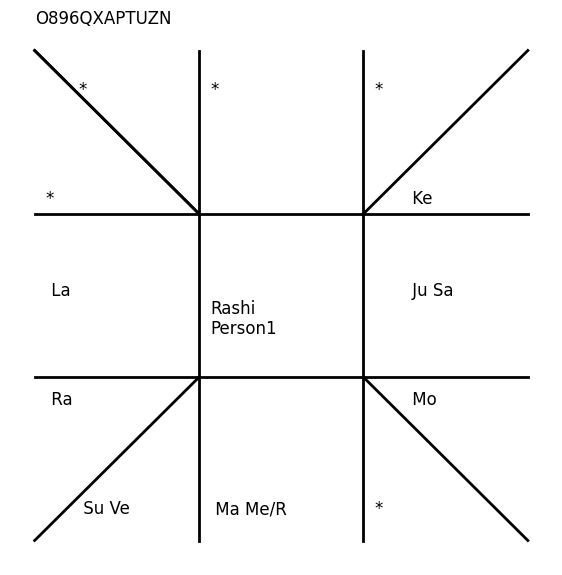

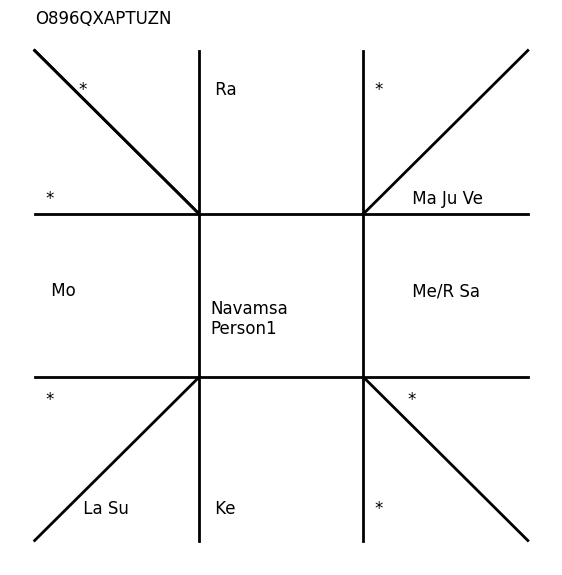

In [19]:
#%%capture

p21.printDasha = True
chart = StoreRetrieveChart()

print(p21.GRashiN)
print(p21.BhavN)
print(p21.BhavA)


ReportFile = genChart('Bengal')

print(p21.GRashiN)
print(p21.BhavN)
print(p21.BhavA)
#ReportFile = genChart('South')


In [27]:
p21utils.SarvaAshtakVarga()

SarvaAshtakVarga | Rashi {'La': 6, 'Su': 6, 'Mo': 4, 'Ma': 11, 'Me': 10, 'Ju': 11, 'Ve': 11, 'Sa': 10, 'Ra': 1, 'Ke': 7}
Su [3, 4, 4, 5, 4, 5, 5, 4, 6, 2, 3, 3]
Mo [5, 5, 5, 5, 3, 2, 2, 7, 4, 2, 3, 6]
Ma [1, 3, 3, 5, 2, 5, 1, 6, 4, 4, 3, 2]
Me [4, 5, 3, 4, 4, 6, 6, 3, 6, 4, 6, 3]
Ju [3, 7, 5, 3, 3, 5, 4, 6, 6, 3, 4, 7]
Ve [5, 5, 5, 4, 3, 6, 6, 6, 4, 2, 2, 4]
Sa [2, 2, 6, 5, 1, 4, 2, 4, 7, 3, 1, 2]
 + [23, 31, 31, 31, 20, 33, 26, 36, 37, 20, 22, 27]  =  337
SarvaAshtakVarga | Bhav [' ', 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
Su [5, 4, 5, 5, 4, 6, 2, 3, 3, 3, 4, 4]
Mo [5, 3, 2, 2, 7, 4, 2, 3, 6, 5, 5, 5]
Ma [5, 2, 5, 1, 6, 4, 4, 3, 2, 1, 3, 3]
Me [4, 4, 6, 6, 3, 6, 4, 6, 3, 4, 5, 3]
Ju [3, 3, 5, 4, 6, 6, 3, 4, 7, 3, 7, 5]
Ve [4, 3, 6, 6, 6, 4, 2, 2, 4, 5, 5, 5]
Sa [5, 1, 4, 2, 4, 7, 3, 1, 2, 2, 2, 6]
 + [31, 20, 33, 26, 36, 37, 20, 22, 27, 23, 31, 31]  =  337


#Gochar Chart

## Gochar Data Preparation

In [28]:
# This cell to be executed ONLY after natal chart has been created, otherwise errors
#
!sed -n 1p peopleData.csv > peopleData2.csv                                  # Copy the Header data
print(p21.gName, p21.SubMoonLong)

#p21.Gochar = True
#if p21.Gochar :

now = datetime.now(pytz.timezone('Asia/Kolkata'))
timeTxt = now.strftime("%-d,%-m,%Y,%-H:%-M")

#
# for Gochar chart for any other time, other than now()
#timeTxt = '31,5,2023,9:16'                # any other time in dd,mm,yyyy,hh:mm format will do
#
#print(timeTxt)

GocharTxt = 'x,'+timeTxt+',5.5,25.43,81.85,IST,standard,'+p21.gName+',nil,nil,nil,nil,nil,nil'                  # Using Lat, Long of Calcutta for Gochar
print(GocharTxt)
with open("peopleData2.csv", 'a') as file1:
    file1.write(GocharTxt)


_Gochar 250.52
x,3,8,2023,16:28,5.5,25.43,81.85,IST,standard,_Gochar,nil,nil,nil,nil,nil,nil


In [29]:
# Load CSV data into Pandas dataframe
#
df = pd.read_csv('peopleData2.csv')
#df.head()

p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']
p21.ChartType = p21.AnalysisType

p21swe.C61_Cast2JSON(df)
print(p21.GLon['La'],p21.GLon['Mo'])

1 records processed, so far
1  records generated and stored in file peopleData.json
250.52 310.784


In [30]:
p21utils.SarvaAshtakVarga()

SarvaAshtakVarga | Rashi {'La': 9, 'Su': 4, 'Mo': 11, 'Ma': 5, 'Me': 5, 'Ju': 1, 'Ve': 5, 'Sa': 11, 'Ra': 1, 'Ke': 7}
Su [4, 5, 2, 4, 4, 4, 4, 4, 4, 3, 6, 4]
Mo [5, 6, 4, 3, 2, 3, 6, 4, 6, 3, 6, 1]
Ma [2, 4, 3, 2, 2, 5, 3, 3, 5, 3, 4, 3]
Me [3, 6, 4, 3, 4, 6, 4, 6, 6, 2, 3, 7]
Ju [6, 6, 7, 3, 5, 5, 4, 3, 4, 6, 3, 4]
Ve [6, 4, 6, 2, 3, 3, 6, 3, 7, 5, 4, 3]
Sa [4, 4, 4, 6, 2, 2, 3, 0, 4, 4, 3, 3]
 + [30, 35, 30, 23, 22, 28, 30, 23, 36, 26, 29, 25]  =  337
SarvaAshtakVarga | Bhav [' ', 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
Su [4, 3, 6, 4, 4, 5, 2, 4, 4, 4, 4, 4]
Mo [6, 3, 6, 1, 5, 6, 4, 3, 2, 3, 6, 4]
Ma [5, 3, 4, 3, 2, 4, 3, 2, 2, 5, 3, 3]
Me [6, 2, 3, 7, 3, 6, 4, 3, 4, 6, 4, 6]
Ju [4, 6, 3, 4, 6, 6, 7, 3, 5, 5, 4, 3]
Ve [7, 5, 4, 3, 6, 4, 6, 2, 3, 3, 6, 3]
Sa [4, 4, 3, 3, 4, 4, 4, 6, 2, 2, 3, 0]
 + [36, 26, 29, 25, 30, 35, 30, 23, 22, 28, 30, 23]  =  337


## Process Gochar Chart

In [ ]:
%%capture

p21.printDasha = True
chart = StoreRetrieveChart()
ReportFile = genChart('Bengal')

#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself.
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

In [ ]:
#!cat peopleData.json

# Leftovers

In [ ]:
#
#Get List of Persons whose charts are found in the database
#
selCond = {}                                              # All Charts
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
#pd.DataFrame(list(p21.kollection.find(selCond,{'pid.name':1,'_id':0})))
pd.DataFrame(list(p21.kollection.find(selCond,{'pid.name':1})))
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))


,_id,pid
0,647033684776acde01f074cd,{'name': '_Gochar'}


In [ ]:
#
# Download last Report File
#
files.download(ReportFile)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm *.doc